# SOLUTION: Q-Learning on FrozenLake

THIS NOTEBOOK SHOWS THE SOLUTION TO THE Q-LEARNING ON FROZENLAKE EXERCISE.

--- 

You've already played around with Q-learning in RL Lab, but now let's implement it ourselves!

The goal is to get familiar with the gym library and implement the core algorithm, so you can understand what's happening in the backend of RL Lab.

## ⚙️ Setup Instructions

**Before running this notebook:**

1. Make sure you've installed dependencies:
   ```bash
   cd examples
   uv sync
   ```

2. Register the Jupyter kernel (first time only):
   ```bash
   uv run python -m ipykernel install --user --name=workshop-rl1-examples --display-name "Python (RL Workshop)"
   ```

3. **Select the correct kernel in VS Code:**
   - Click "Select Kernel" (top right)
   - Click "Jupyter Kernel"
   - Select **"Python (RL Workshop)"**

---


### 0. Get familiar with the gym library and its FrozenLake environment

Gymnasium (gym) is an open source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API. 
The documentation website is at [gymnasium.farama.org](https://gymnasium.farama.org). More info can be found on their [GitHub page](https://github.com/Farama-Foundation/Gymnasium) and by joining their [Discord server](https://discord.gg/bnJ6kubTg6).

In the next cell, we import gym and create the FrozenLake environment. We play a single episode with random actions to see how it works. 
To see, which arguments are valid for `gym.make('FrozenLake-v1')`, check the [documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).


---

**!!! IMPORTANT for MacOS !!!**

The render_mode argument in `gym.make` determines how the environment is visualized. 
`render_mode='human'` opens a pygame window to visualize the environment live while the agent interacts with it.

On MacOS, there are known issues with pygame. 

For example, you may not be able to close the window by clicking the 'X' button. Instead, you may need to force quit the Python process. 
FOR NOW, JUST KEEP THE WINDOW RUNNING IN THE BACKGROUND AND CONTINUE WITH THE NOTEBOOK.

We will use other render modes later, for example 'rgb_array', which returns image frames as numpy arrays, useful for video playback.

---

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Create FrozenLake environment (non-slippery for easier learning)
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='human')
# ---------------------------------------------------
# !!! IMPORTANT for MacOS !!!
# The render_mode argument in gym.make determines how the environment is visualized. 
# render_mode='human' opens a pygame window to visualize the environment live while the agent interacts with it.. On MacOS, there are known issues with pygame. 
# For example, you may not be able to close the window by clicking the 'X' button. Instead, you may need to force quit the Python process. 
# FOR NOW, JUST KEEP THE WINDOW RUNNING IN THE BACKGROUND AND CONTINUE WITH THE NOTEBOOK.
# We will use other render modes later, for example 'rgb_array', which returns image frames as numpy arrays, useful for video playback.
# ---------------------------------------------------

# Get environment dimensions
num_states = env.observation_space.n
num_actions = env.action_space.n

print(f"FrozenLake Environment:")
print(f"  States: {num_states} (4x4 grid)")
print(f"  Actions: {num_actions} (LEFT=0, DOWN=1, RIGHT=2, UP=3)")
print(f"\nGoal: Navigate from Start (S) to Goal (G) without falling in Holes (H)")

# Reset environment to start a new episode
observation, info = env.reset()
# observation: what the agent can "see" - here, it's the current state (0-15)
# info: extra debugging information (usually not needed for basic learning)
print(f"Starting observation: {observation}")

# Let's run a single episode with random actions to see how it works
episode_over = False
total_reward = 0
while not episode_over:
    # Choose an action: 
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated

print(f"Episode finished! Total reward: {total_reward}")
env.close()

FrozenLake Environment:
  States: 16 (4x4 grid)
  Actions: 4 (LEFT=0, DOWN=1, RIGHT=2, UP=3)

Goal: Navigate from Start (S) to Goal (G) without falling in Holes (H)


/Users/david.goll/Documents/projects/workshop-rl1-introduction/examples/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Starting observation: 0
Episode finished! Total reward: 0


## 1. Setup

From now on, we will use render_mode='rgb_array' to avoid issues for macOS users. In the next cell, we recreate the environment but now also with a new map.

FrozenLake Environment:
  States: 64 (4x4 grid)
  Actions: 4 (LEFT=0, DOWN=1, RIGHT=2, UP=3)

Goal: Navigate from Start (S) to Goal (G) without falling in Holes (H)


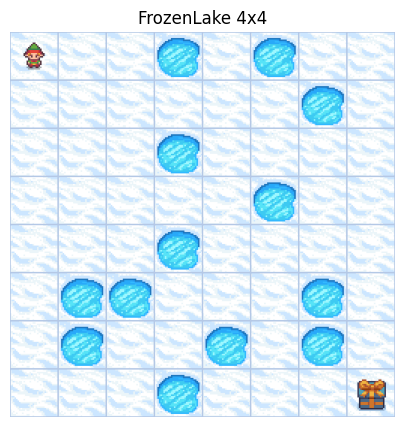


✓ Environment created successfully!


In [2]:
# Instead of using the standard 4x4 map, we can create our own custom map as follows:
# S = Start, F = Frozen (safe), H = Hole (fall to your doom), G = Goal
# To make things more interesting, we use a larger 8x8 map here.
custom_map = [
    "SFFHFHFF",
    "FFFFFFHF",
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFHFFFG",
]

# To use the standard 4x4 map, you can simply uncomment the following line to override the custom_map variable:
# custom_map = [
#     "SFFF",
#     "FHFH",
#     "FFFH",
#     "HFFG"
# ]

# Create FrozenLake environment with 'rgb_array' render mode and custom map
env = gym.make('FrozenLake-v1', desc=custom_map, is_slippery=False, render_mode='rgb_array')

# Get environment dimensions
num_states = env.observation_space.n
num_actions = env.action_space.n

print(f"FrozenLake Environment:")
print(f"  States: {num_states} (4x4 grid)")
print(f"  Actions: {num_actions} (LEFT=0, DOWN=1, RIGHT=2, UP=3)")
print(f"\nGoal: Navigate from Start (S) to Goal (G) without falling in Holes (H)")

# Visualize our larger custom environment
env.reset()
frame = env.render()

plt.figure(figsize=(5, 5))
plt.imshow(frame)
plt.title("FrozenLake 4x4")
plt.axis('off')
plt.show()

print("\n✓ Environment created successfully!")

## 2. Q-Learning Implementation

Q-Learning learns a Q-table where `Q[state, action]` represents the expected reward for taking an action in a state.

**The Q-Learning Update Rule:**

```
Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
```

Where:
- `α` (alpha) = learning rate (how much to update)
- `γ` (gamma) = discount factor (how much to value future rewards)
- `r` = immediate reward
- `s'` = next state

### Helper Function

First, let's define a helper to break ties randomly when multiple actions have the same Q-value, and a function to initialize the Q-table.

In [3]:
def argmax_random_tiebreak(q_values):
    """
    Select action with highest Q-value, breaking ties randomly. 
    This function is needed because np.argmax returns the first occurrence of the maximum value, which can bias action selection.
    Critical for exploration when Q-values are tied (e.g., all zeros initially).
    """
    max_value = np.max(q_values)
    max_actions = np.where(q_values == max_value)[0]
    return np.random.choice(max_actions)

def initialize_q_table(num_states, num_actions):
    """
    Initialize Q-table. For now, we initialize all Q-values to zero. If desired, you can experiment with different initializations.
    """
    return np.zeros((num_states, num_actions))

### YOUR TASK: Implement the Q-Learning Update

Fill in the function below to implement the Q-learning update rule. This is the **heart of the algorithm**!

In [1]:
def q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor):
    """
    Update Q-table using the Q-learning rule.
    
    TODO: Implement the Q-learning update equation:
    Q(s,a) ← Q(s,a) + α[r + γ·max(Q(s',a')) - Q(s,a)]
    
    Hints:
    1. Find the maximum Q-value for the next state: best_next_q = argmax_random_tiebreak(q_table[next_state])
    2. Calculate TD target: td_target = r + γ·max(Q(s',a'))
    3. Calculate TD error: td_error = td_target - Q(s,a)
    4. Update Q-value: q_table[state, action] += α * td_error
    """
    # Find the best action for the next state
    best_next_action = argmax_random_tiebreak(q_table[next_state])
    # Get the Q-value for that best action
    best_next_q = q_table[next_state, best_next_action]
    # calculate TD target - this is the new information we got
    td_target = reward + discount_factor * best_next_q
    # calculate TD error - how much we were off compared to our previous estimate
    td_error = td_target - q_table[state, action]
    # update Q-value - the learning rate governs how much we adjust our estimate (smaller α = slower but more stable learning, higher α = faster but unstable learning) 
    q_table[state, action] += learning_rate * td_error

def epsilon_greedy_action_selection(q_table, state, exploration_rate):
    """
    Select action using epsilon-greedy policy.

    TODO: Implement epsilon-greedy action selection.
    With probability exploration_rate, select a random action (exploration).
    Otherwise, select the best action according to the Q-table (exploitation).

    Hints:
    1. Generate a random number between 0 and 1: rand = np.random.rand()
    2. If rand < exploration_rate, select a random action of the action space (env.action_space.sample()).
    3. Otherwise, select the best action using argmax_random_tiebreak on the Q-values for the current state.
    """
    # delete next lines before upload
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()  # Random action
    else:
        return argmax_random_tiebreak(q_table[state])  # Best action

### Training Loop (Pre-filled)

The complete training loop is provided. It uses your `q_learning_update` function:

In [2]:
def train(env, num_episodes=500, learning_rate=0.1, discount_factor=0.95, exploration_rate=0.1):
    """
    Train Q-learning agent on the environment.
    """
    # Initialize Q-table (default to zeros, but if desired, you can experiment with different initializations by changing the function in the cell above) 
    q_table = initialize_q_table(num_states, num_actions)
    episode_rewards = [] # track total rewards per episodes to monitor progress later on
    
    for episode in range(num_episodes):
        state, _ = env.reset() # reset the environment
        total_reward = 0 # keep track of total reward per episode. For FrozenLake, rewards are sparse (0 or 1 at the end). For other environments, rewards may be more frequent.
        done = False # flag to indicate if episode is over
        steps = 0 # count steps taken in the episode
        max_steps = 1000  # Prevent infinite loops
        
        while not done and steps < max_steps:
            # Epsilon-greedy action selection
            action = epsilon_greedy_action_selection(q_table, state, exploration_rate)
            
            # Take action and observe outcome
            # The env.step function handles the environment dynamics and returns the next state and reward and information about episode termination.
            next_state, reward, terminated, truncated, _ = env.step(action) # terminated: episode ended successfully or fell in hole; truncated: episode ended due to time limit
            done = terminated or truncated
            total_reward += reward
            
            # Update Q-table using your function
            q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor)
            
            state = next_state
            steps += 1
        
        episode_rewards.append(total_reward)
        
        # Progress update every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes} | Avg Reward (last 100): {avg_reward:.3f}")
    
    return q_table, episode_rewards

### Run Training

Now let's train the agent! 

In [6]:
print("Training Q-Learning agent...\n")
q_table, rewards = train(env, num_episodes=int(5e4), learning_rate=0.1, discount_factor=0.95, exploration_rate=0.1)
print("\n✓ Training complete!")

Training Q-Learning agent...

Episode 100/50000 | Avg Reward (last 100): 0.000
Episode 200/50000 | Avg Reward (last 100): 0.000
Episode 300/50000 | Avg Reward (last 100): 0.000
Episode 400/50000 | Avg Reward (last 100): 0.000
Episode 500/50000 | Avg Reward (last 100): 0.000
Episode 600/50000 | Avg Reward (last 100): 0.000
Episode 700/50000 | Avg Reward (last 100): 0.000
Episode 800/50000 | Avg Reward (last 100): 0.000
Episode 900/50000 | Avg Reward (last 100): 0.000
Episode 1000/50000 | Avg Reward (last 100): 0.000
Episode 1100/50000 | Avg Reward (last 100): 0.000
Episode 1200/50000 | Avg Reward (last 100): 0.000
Episode 1300/50000 | Avg Reward (last 100): 0.000
Episode 1400/50000 | Avg Reward (last 100): 0.000
Episode 1500/50000 | Avg Reward (last 100): 0.000
Episode 1600/50000 | Avg Reward (last 100): 0.000
Episode 1700/50000 | Avg Reward (last 100): 0.000
Episode 1800/50000 | Avg Reward (last 100): 0.000
Episode 1900/50000 | Avg Reward (last 100): 0.000
Episode 2000/50000 | Avg Rewa

## 3. Results

Let's visualize the training progress by plotting the rewards over episodes.

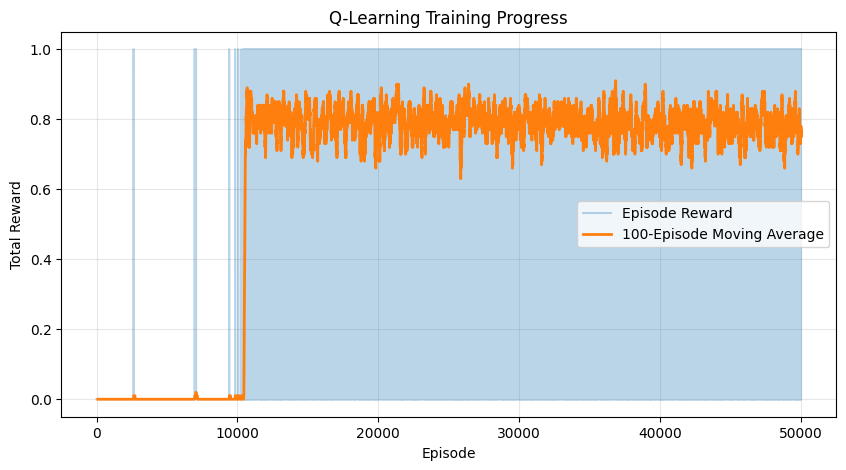

In [7]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label='Episode Reward')

# Moving average for smoothing
window = 100
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(rewards)), moving_avg, linewidth=2, label=f'{window}-Episode Moving Average')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

And now let's play back the learned policy! To avoid the MacOS pygame issues, we will display a video of the agent playing instead of rendering live.

In [8]:
# Visualize the learned policy in action
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def play_episode_with_policy(env, q_table, max_steps=100):
    """
    Play one episode using the learned policy and record frames.
    """
    frames = []
    state, _ = env.reset()
    frames.append(env.render())
    
    done = False
    steps = 0
    total_reward = 0
    
    while not done and steps < max_steps:
        # Select best action (greedy policy, no exploration)
        action = argmax_random_tiebreak(q_table[state])
        
        # Take action
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
        
        # Record frame
        frames.append(env.render())
        steps += 1
    
    return frames, total_reward, done

# Play episode and collect frames
print("Playing episode with learned policy...")
frames, total_reward, success = play_episode_with_policy(env, q_table)

print(f"Episode completed in {len(frames)-1} steps")
print(f"Total reward: {total_reward}")
print(f"Success: {'✓ Reached goal!' if success and total_reward > 0 else '✗ Failed'}")

# Create animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
img = ax.imshow(frames[0])

def update(frame_idx):
    img.set_array(frames[frame_idx])
    ax.set_title(f'Step {frame_idx}/{len(frames)-1}')
    return [img]

anim = FuncAnimation(fig, update, frames=len(frames), interval=300, blit=True, repeat=True)
plt.close()  # Prevent static display

# Display animation
HTML(anim.to_jshtml())

Playing episode with learned policy...
Episode completed in 14 steps
Total reward: 1
Success: ✓ Reached goal!


In [9]:
# Show learned policy (best action per state)
# Determine grid dimensions from the custom map
grid_rows = len(custom_map)
grid_cols = len(custom_map[0])

policy = np.argmax(q_table, axis=1).reshape(grid_rows, grid_cols)
action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}

print("\n🎯 Learned Policy (best action for each state):")
print("\n", end="")
for i in range(grid_rows):
    for j in range(grid_cols):
        tile = custom_map[i][j]
        
        if tile == 'H':
            print("H  ", end="")
        elif tile == 'G':
            print("G  ", end="")
        else:  # `S`(start) and 'F' (frozen)
            state = i * grid_cols + j
            action = policy[i, j]
            print(f"{action_symbols[action]}  ", end="")
    print()


🎯 Learned Policy (best action for each state):

↓  ↓  ↓  H  ↓  H  ←  ←  
↓  ↓  ↓  ←  ↓  ←  H  ↓  
→  ↓  ↓  H  ↓  ←  →  ↓  
→  →  →  →  ↓  H  ↓  ↓  
→  ↑  ↑  H  →  →  →  ↓  
↑  H  H  →  ↑  ↑  H  ↓  
←  H  ←  ←  H  ↑  H  ↓  
←  ←  ←  H  ←  ←  →  G  


---

## Congratulations!

You've implemented the core of Q-Learning! 

### Next steps:
1. **Challenge**: Modify the code to use `is_slippery=True` - how does performance change?
2. Try out other environments in gymnasium, e.g., `Taxi-v3` or `CliffWalking-v0`.
3. Explore more advanced algorithms like Deep Q-Networks (DQN) using libraries like Stable Baselines3 on more complex environments. (notebook coming soon!)